<a href="https://colab.research.google.com/github/Pam-Pam29/Group18-Formative-2-Text-Classification/blob/main/RNN/Group18_Formative_2_Text_Classification__RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Text classification is a fundamental task in Natural Language Processing (NLP) with applications such as sentiment analysis, topic detection, and spam filtering.  
This project focuses on **Text classification** into three classes: *negative, neutral, and positive*.

The objective of this experiment is to evaluate how different **word embedding techniques** interact with **Recurrent Neural Network (RNN) architectures**, specifically a **Bidirectional RNN (BiRNN)**.  
We compare the performance of **TF-IDF**, **Word2Vec CBOW**, and **Word2Vec Skip-gram** embeddings using the same model structure for fair comparison.


In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Dataset Description

The dataset consists of labeled text samples used for sentiment analysis with three sentiment classes:
- Negative
- Neutral
- Positive

The dataset contains approximately 5,000 samples and exhibits class imbalance, with the *neutral* class being the majority.  
To address this issue, **class weighting** was applied during model training.


In [2]:
url = 'https://raw.githubusercontent.com/Pam-Pam29/Group18-Formative-2-Text-Classification/refs/heads/main/dataset/data.csv'
df = pd.read_csv(url)
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## Exploratory Data Analysis

Exploratory analysis was conducted to understand:
- Class distribution
- Text length patterns
- Vocabulary size

The analysis revealed an imbalanced class distribution, motivating the use of **class weights** during training.  
Text lengths were capped at a maximum sequence length of 100 tokens to ensure consistency across models.


In [3]:
# print the information of Df
print("Dataframe info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Sentiments:")
print(df['Sentiment'].unique())

print("\nSentiment Distribution:")
print(df['Sentiment'].value_counts())


Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB

Missing Values:
Sentence     0
Sentiment    0
dtype: int64

Unique Sentiments:
['positive' 'negative' 'neutral']

Sentiment Distribution:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64



 Sentiment Distribution 
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Class percentages:
Sentiment
neutral     53.577542
positive    31.701472
negative    14.720986
Name: proportion, dtype: float64


/tmp/ipython-input-276900675.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment', ax=axes[0], palette='viridis')


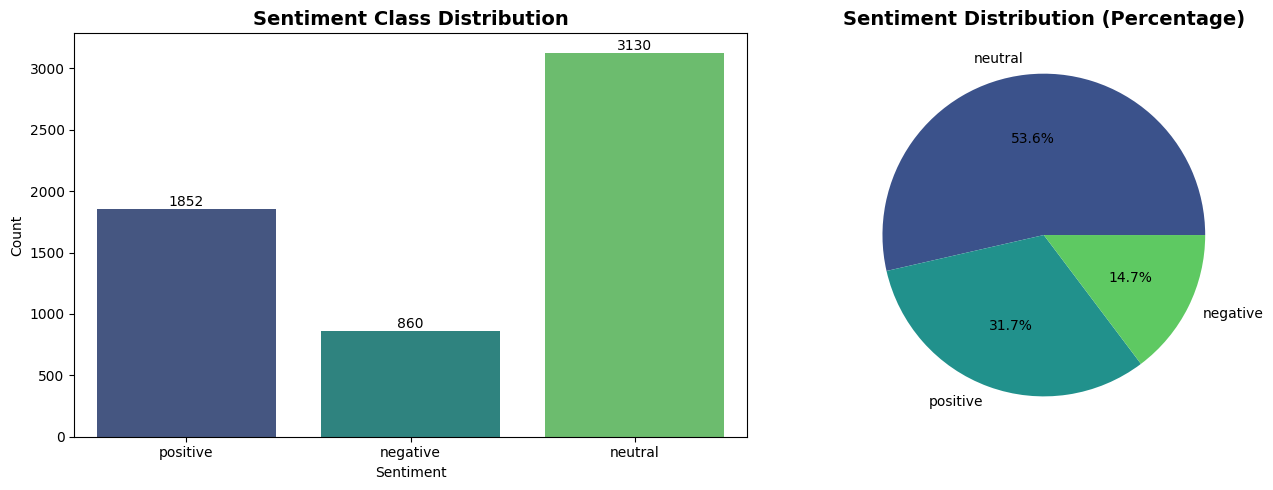

In [116]:
#  Class Distribution
print("\n Sentiment Distribution ")
print(df['Sentiment'].value_counts())
print(f"\nClass percentages:")
print(df['Sentiment'].value_counts(normalize=True) * 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='Sentiment', ax=axes[0], palette='viridis')
axes[0].set_title('Sentiment Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
for container in axes[0].containers:
    axes[0].bar_label(container)

# Pie chart
sentiment_counts = df['Sentiment'].value_counts()
axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
           colors=sns.color_palette('viridis', len(sentiment_counts)))
axes[1].set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_1_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


--- Text Statistics ---
Average sentence length: 117.02 characters
Average word count: 21.00 words
Max word count: 81
Min word count: 2


/tmp/ipython-input-3874343820.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sentiment', y='word_count', ax=axes[1, 0], palette='Set2')
/tmp/ipython-input-3874343820.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Sentiment', y='sentence_length', ax=axes[1, 1], palette='Set3')


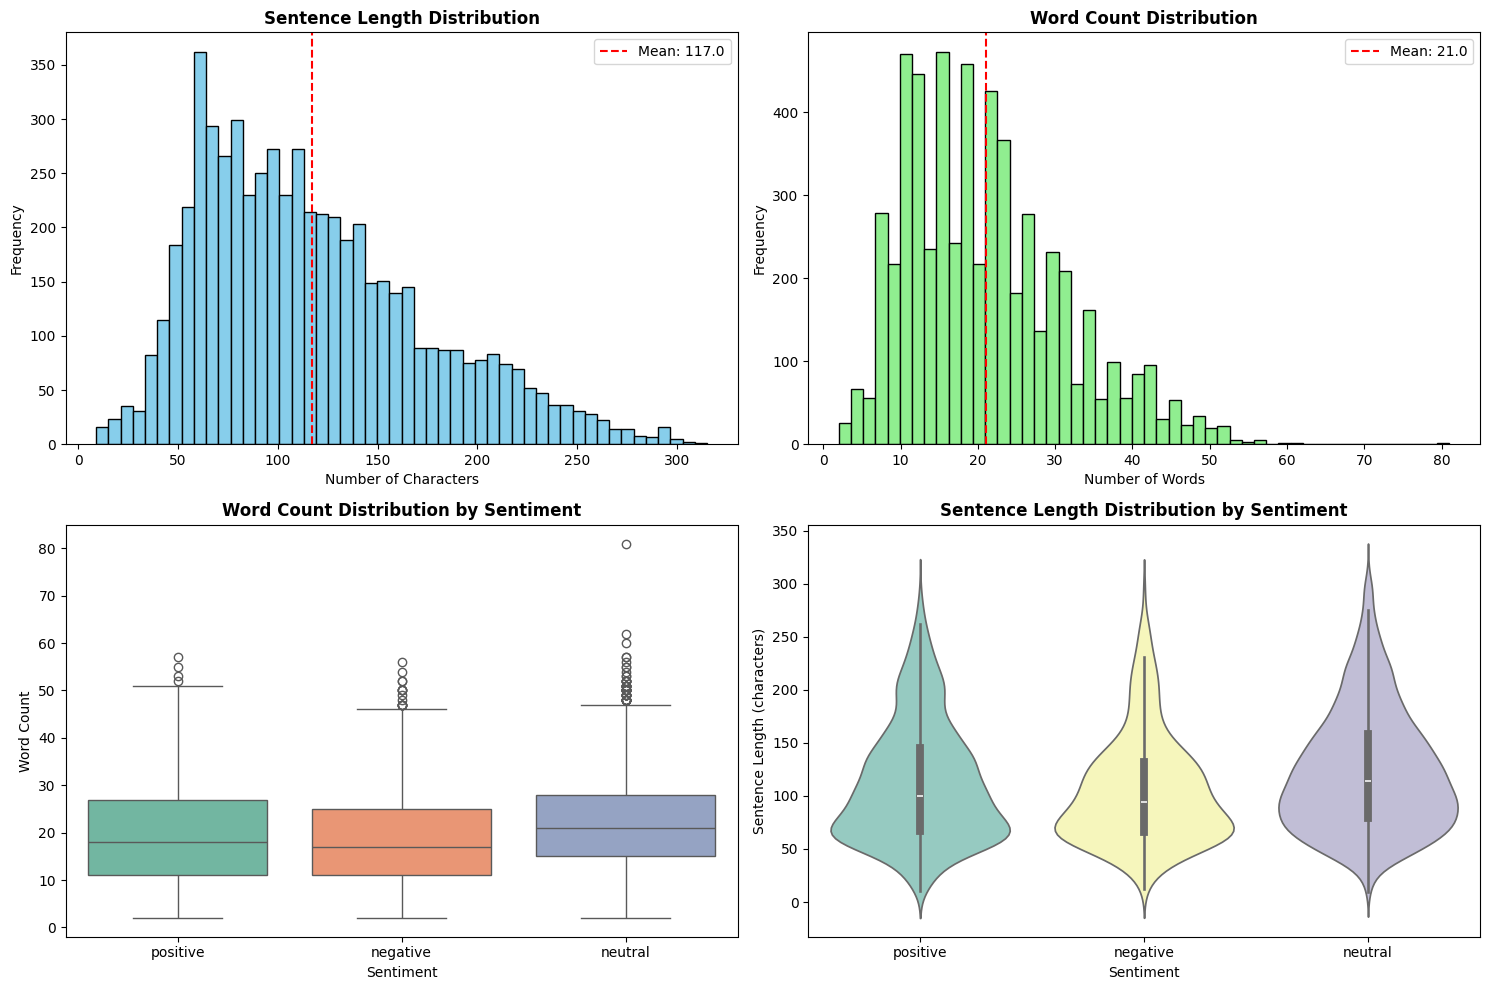

In [117]:
# Text Length Analysis
df['sentence_length'] = df['Sentence'].apply(len)
df['word_count'] = df['Sentence'].apply(lambda x: len(str(x).split()))

print(f"\n--- Text Statistics ---")
print(f"Average sentence length: {df['sentence_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Max word count: {df['word_count'].max()}")
print(f"Min word count: {df['word_count'].min()}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentence length distribution
axes[0, 0].hist(df['sentence_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Sentence Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Characters')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['sentence_length'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["sentence_length"].mean():.1f}')
axes[0, 0].legend()

# Word count distribution
axes[0, 1].hist(df['word_count'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['word_count'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["word_count"].mean():.1f}')
axes[0, 1].legend()

# Word count by sentiment (boxplot)
sns.boxplot(data=df, x='Sentiment', y='word_count', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Word Count Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Word Count')

# Sentence length by sentiment (violin plot)
sns.violinplot(data=df, x='Sentiment', y='sentence_length', ax=axes[1, 1], palette='Set3')
axes[1, 1].set_title('Sentence Length Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Sentence Length (characters)')

plt.tight_layout()
plt.savefig('eda_2_text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Add new columns for text xcter
df['sentence_length'] = df['Sentence'].apply(len)
df['word_count'] = df['Sentence'].apply(lambda x: len(x.split()))

print("\nDescriptive statistics for sentence_length and word_count:")
print(df[['sentence_length', 'word_count']].describe())


Descriptive statistics for sentence_length and word_count:
       sentence_length   word_count
count      5842.000000  5842.000000
mean        117.022253    21.004793
std          56.420425    10.306465
min           9.000000     2.000000
25%          72.000000    13.000000
50%         107.000000    19.000000
75%         150.000000    27.000000
max         315.000000    81.000000


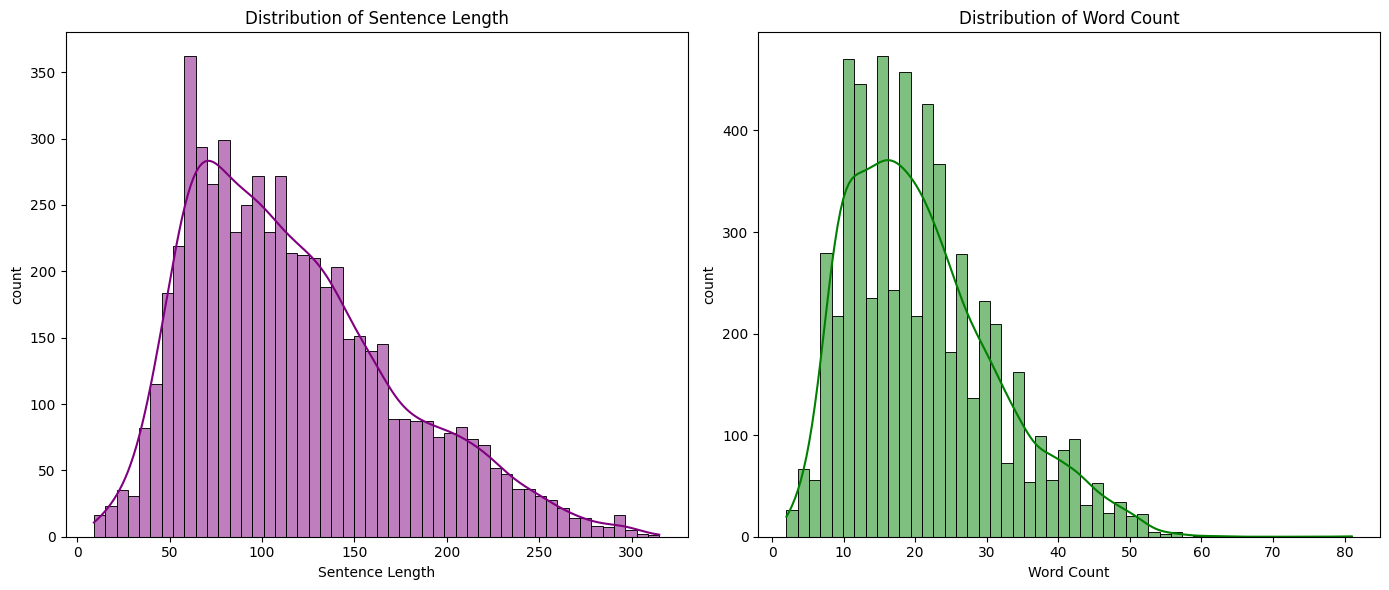

In [6]:
# Create and display histograms for 'sentence_length' and 'word_count'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['sentence_length'], bins=50, kde=True, color='purple')
plt.title('Distribution of Sentence Length')
plt.xlabel('Sentence Length')
plt.ylabel('count')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=50, kde=True, color='green')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('count')

plt.tight_layout()
plt.show()

## Text Preprocessing

A shared preprocessing pipeline was used across all experiments:
- Tokenization
- Lowercasing
- Padding and truncation to a fixed sequence length
- Label encoding and one-hot encoding

For Word2Vec-based models, tokenized text sequences were converted into index-based representations aligned with the trained embedding vocabulary.


In [7]:
# Necessary import for text data preprocessing & embedding
! pip install nltk
! pip install gensim
import nltk
import re

In [8]:
# Download dictionary for NLTK data
try:
  nltk.data.find('corpora/stopwords')
except LookupError:
  nltk.download('stopwords')
try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')
try:
  nltk.data.find('tokenizers/punkt_tab')
except LookupError:
  nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punction
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers and special xters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remaining non-alphanumerical xcter.
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # remove stopwords
    word_tokens = word_tokenize(text)
    filtered_sentence = [word for word in word_tokens if word not in stop_words]
    text = " ". join(filtered_sentence)
    return text

# Apply the preprocessing function
df['cleaned_sentence'] = df['Sentence'].apply(preprocess_text)

print("First 5 rows of the preprocessed DataFrame:")
print(df[['Sentence', 'cleaned_sentence']].head())
print("\nInfo on the updated DF with 'cleaned_sentence' column:")
print(df.info())


First 5 rows of the preprocessed DataFrame:
                                            Sentence  \
0  The GeoSolutions technology will leverage Bene...   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...   
2  For the last quarter of 2010 , Componenta 's n...   
3  According to the Finnish-Russian Chamber of Co...   
4  The Swedish buyout firm has sold its remaining...   

                                    cleaned_sentence  
0  geosolutions technology leverage benefon gps s...  
1                       esi lows bk real possibility  
2  last quarter componenta net sales doubled eurm...  
3  according finnishrussian chamber commerce majo...  
4  swedish buyout firm sold remaining percent sta...  

Info on the updated DF with 'cleaned_sentence' column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Sentence          5842 non-nul

In [9]:
# ============================================================
# DATA PREPARATION - RUN THIS ONCE FOR ALL MODELS
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

# Encode labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])

# Split data
X = df['cleaned_sentence']
y = df['sentiment_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize IMMEDIATELY after split
train_tokens = [word_tokenize(text) for text in X_train]
test_tokens = [word_tokenize(text) for text in X_test]

# VERIFY alignment
print("\n=== VERIFICATION ===")
for i in range(3):
    print(f"\nOriginal: {X_train.iloc[i][:100]}")
    print(f"Tokens: {train_tokens[i][:20]}")


=== VERIFICATION ===

Original: floor area yliopistonrinne project sq sq ft building gross area total sq total facilities let
Tokens: ['floor', 'area', 'yliopistonrinne', 'project', 'sq', 'sq', 'ft', 'building', 'gross', 'area', 'total', 'sq', 'total', 'facilities', 'let']

Original: compensation news opinions distributions
Tokens: ['compensation', 'news', 'opinions', 'distributions']

Original: rt acinvestorblog aapl still track
Tokens: ['rt', 'acinvestorblog', 'aapl', 'still', 'track']


## Model Architecture: Bidirectional RNN

All experiments used the same Bidirectional RNN architecture for consistency:
- Embedding layer (TF-IDF or Word2Vec initialized)
- Two Bidirectional SimpleRNN layers
- Fully connected Dense layers with ReLU activation
- Batch normalization and dropout for regularization
- Softmax output layer for multi-class classification

The model was trained using the Adam optimizer and categorical cross-entropy loss.


## Bidirectional RNN + TF-IDF
### Overview
This implementation combines Bidirectional Recurrent Neural Networks (BiRNN) with TF-IDF (Term Frequency-Inverse Document Frequency) features for sentiment analysis.

- TF-IDF is not optimal for RNN architectures because:

- TF-IDF creates bag-of-words representations (no sequence information)
- RNNs are designed for sequential temporal data
- Reshaping TF-IDF features into sequences is artificial

Unlike Word2Vec embeddings, TF-IDF does not preserve word order or contextual relationships.

To maintain architectural consistency, TF-IDF features were reshaped and used as input to a Bidirectional RNN, although this representation is not inherently sequential.


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow/Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [11]:
#  TF-IDF VECTORIZATION
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_config = {
    'max_features': 3000,
    'ngram_range': (1, 2),
    'min_df': 2,
    'max_df': 0.8
}

print(f"TF-IDF Configuration:")
print(f"  - Max features: {tfidf_config['max_features']}")
print(f"  - N-gram range: {tfidf_config['ngram_range']}")
print(f"  - Min document frequency: {tfidf_config['min_df']}")
print(f"  - Max document frequency: {tfidf_config['max_df']}")

# Create and fit vectorizer
tfidf_vectorizer = TfidfVectorizer(**tfidf_config)

# Transform text to TF-IDF features
print("\nTransforming training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print("Transforming test data...")
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert sparse matrices to dense arrays
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

print(f"\n TF-IDF Vectorization Complete:")
print(f"   - Training shape: {X_train_tfidf.shape}")
print(f"   - Test shape: {X_test_tfidf.shape}")
print(f"   - Vocabulary size: {len(tfidf_vectorizer.vocabulary_)} unique terms")
print(f"   - Feature range: [{X_train_tfidf.min():.4f}, {X_train_tfidf.max():.4f}]")

TF-IDF Configuration:
  - Max features: 3000
  - N-gram range: (1, 2)
  - Min document frequency: 2
  - Max document frequency: 0.8

Transforming training data...
Transforming test data...

 TF-IDF Vectorization Complete:
   - Training shape: (4673, 3000)
   - Test shape: (1169, 3000)
   - Vocabulary size: 3000 unique terms
   - Feature range: [0.0000, 1.0000]


In [12]:
#  RESHAPE FOR RNN INPUT

timesteps = 50
features_per_step = 60
total_features = timesteps * features_per_step

print(f"Reshape Configuration:")
print(f"  - Timesteps: {timesteps}")
print(f"  - Features per timestep: {features_per_step}")
print(f"  - Total features needed: {total_features}")

# Pad or truncate features to match required size
current_features = X_train_tfidf.shape[1]
print(f"\nCurrent feature count: {current_features}")

if current_features < total_features:
    # Pad with zeros if we have fewer features
    pad_width = total_features - current_features
    print(f"Padding with {pad_width} zeros...")
    X_train_padded = np.pad(X_train_tfidf, ((0, 0), (0, pad_width)), mode='constant')
    X_test_padded = np.pad(X_test_tfidf, ((0, 0), (0, pad_width)), mode='constant')
else:
    # Truncate if we have more features
    print(f"Truncating to {total_features} features...")
    X_train_padded = X_train_tfidf[:, :total_features]
    X_test_padded = X_test_tfidf[:, :total_features]

# Reshape from 2D to 3D
# From: (samples, 3000)
# To:   (samples, 50, 60)
n_train_samples = X_train_padded.shape[0]
n_test_samples = X_test_padded.shape[0]

X_train_rnn = X_train_padded.reshape(n_train_samples, timesteps, features_per_step)
X_test_rnn = X_test_padded.reshape(n_test_samples, timesteps, features_per_step)

print(f"\n Reshaping Complete:")
print(f"   - Training: {X_train_tfidf.shape} → {X_train_rnn.shape}")
print(f"   - Test: {X_test_tfidf.shape} → {X_test_rnn.shape}")
print(f"   - Shape format: (samples, timesteps, features)")


Reshape Configuration:
  - Timesteps: 50
  - Features per timestep: 60
  - Total features needed: 3000

Current feature count: 3000
Truncating to 3000 features...

 Reshaping Complete:
   - Training: (4673, 3000) → (4673, 50, 60)
   - Test: (1169, 3000) → (1169, 50, 60)
   - Shape format: (samples, timesteps, features)


In [13]:
#  PREPARE LABELS

from tensorflow.keras.utils import to_categorical

num_classes = 3 # Define num_classes

print(f"Converting labels to one-hot encoding ({num_classes} classes)...")
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

print(f"\n Label Encoding Complete:")
print(f"   - Training labels: {y_train.shape} → {y_train_onehot.shape}")
print(f"   - Test labels: {y_test.shape} → {y_test_onehot.shape}")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    percentage = (count / len(y_train)) * 100
    print(f"   - {label_encoder.classes_[label]}: {count} ({percentage:.1f}%)")

Converting labels to one-hot encoding (3 classes)...

 Label Encoding Complete:
   - Training labels: (4673,) → (4673, 3)
   - Test labels: (1169,) → (1169, 3)

Class distribution in training set:
   - negative: 685 (14.7%)
   - neutral: 2508 (53.7%)
   - positive: 1480 (31.7%)


In [14]:
#  CLASS WEIGHTS
from collections import Counter
class_counts = Counter(y_train)
total_samples = sum(class_counts.values())
class_weights = {i: total_samples/(3*count) for i, count in class_counts.items()}
print(f" Class weights: {class_weights}")


 Class weights: {1: 0.6210792131844763, 2: 1.0524774774774774, 0: 2.273965936739659}


In [15]:
from tensorflow.keras import backend as K

# Clear any previous models from memory
K.clear_session()

In [16]:
model = Sequential(name="BiRNN_TF-IDF")
model.add(Bidirectional(
    SimpleRNN(
        units=128,
        activation='tanh',
        return_sequences=True,
        dropout=0.3,
        recurrent_dropout=0.2
    ),
    input_shape=(timesteps, features_per_step)
))

model.add(Bidirectional(
    SimpleRNN(
        units=64,
        activation='tanh',
        dropout=0.3,
        recurrent_dropout=0.2
    )
))


model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n Model Architecture Built Successfully!")
print("\nModel Summary:")
print("="*60)
model.summary()
print("="*60)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 Model Architecture Built Successfully!

Model Summary:


Model: "BiRNN_TF-IDF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │        48,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,163 (391.26 KB)

 Trainable params: 100,035 (390.76 KB)

 Non-trainable params: 128 (512.00 B)

In [27]:
# CONFIGURE TRAINING CALLBACKS
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,  # More patience
    restore_best_weights=True,
    verbose=1
)

print("\n Training callbacks configured!")


 Training callbacks configured!


In [28]:
# VERIFY CLASS WEIGHTS
print("\n" + "="*60)
print("CLASS WEIGHT VERIFICATION")
print("="*60)
print(f"Class weights dictionary: {class_weights}")
print(f"Type: {type(class_weights)}")
print(f"Is empty? {len(class_weights) == 0}")

for class_id, weight in class_weights.items():
    class_name = label_encoder.classes_[class_id]
    print(f"  Class {class_id} ({class_name}): weight = {weight:.4f}")

# Check training label distribution
print("\nTraining set distribution:")
for i in range(3):
    count = (y_train == i).sum()
    percentage = count / len(y_train) * 100
    print(f"  Class {i} ({label_encoder.classes_[i]}): {count} samples ({percentage:.1f}%)")
print("="*60)


CLASS WEIGHT VERIFICATION
Class weights dictionary: {1: 0.6210792131844763, 2: 1.0524774774774774, 0: 2.273965936739659}
Type: <class 'dict'>
Is empty? False
  Class 1 (neutral): weight = 0.6211
  Class 2 (positive): weight = 1.0525
  Class 0 (negative): weight = 2.2740

Training set distribution:
  Class 0 (negative): 685 samples (14.7%)
  Class 1 (neutral): 2508 samples (53.7%)
  Class 2 (positive): 1480 samples (31.7%)


In [29]:
# TRAIN THE MODEL
history = model.fit(
    X_train_rnn, y_train_onehot,
    validation_split=0.2,
    epochs=50,  # Fewer epochs
    batch_size=32,  # Standard batch size
    callbacks=[early_stop],
    class_weight=class_weights,  # ← CRITICAL!
    verbose=1
)
print("\n Training Complete!")


Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.3618 - loss: 1.1752 - val_accuracy: 0.1647 - val_loss: 1.1586
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3220 - loss: 1.1673 - val_accuracy: 0.4524 - val_loss: 1.0835
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3312 - loss: 1.1411 - val_accuracy: 0.3519 - val_loss: 1.0975
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.3581 - loss: 1.1148 - val_accuracy: 0.2086 - val_loss: 1.1062
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3325 - loss: 1.1083 - val_accuracy: 0.4374 - val_loss: 1.0835
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.3462 - loss: 1.0990 - val_accuracy: 0.2481 - val_loss: 1.1216
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.3504 - loss: 1.0969 - val_accuracy: 0.3412 - val_loss: 1.1026
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.3720 - loss: 1.0721 - 

In [20]:
# Evaluate on test set
print("\nEvaluating model on held-out test set...")
test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test_onehot, verbose=0)

print(f"\nTest Set Results:")
print(f"   - Test Loss: {test_loss:.4f}")
print(f"   - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Generate predictions
y_pred_probs = model.predict(X_test_rnn, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred_classes,
    target_names=[str(c) for c in label_encoder.classes_]
))


Evaluating model on held-out test set...

Test Set Results:
   - Test Loss: 0.9936
   - Test Accuracy: 0.5321 (53.21%)

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       175
     neutral       0.53      1.00      0.69       622
    positive       0.00      0.00      0.00       372

    accuracy                           0.53      1169
   macro avg       0.18      0.33      0.23      1169
weighted avg       0.28      0.53      0.37      1169



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
y_pred_probs = model.predict(X_test_rnn, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test.values if hasattr(y_test, 'values') else y_test

print(f"Predictions generated: {len(y_pred_classes)} samples")


Predictions generated: 1169 samples


In [22]:
class_names = [str(c) for c in label_encoder.classes_]
print("Class names:", class_names)

Class names: ['negative', 'neutral', 'positive']


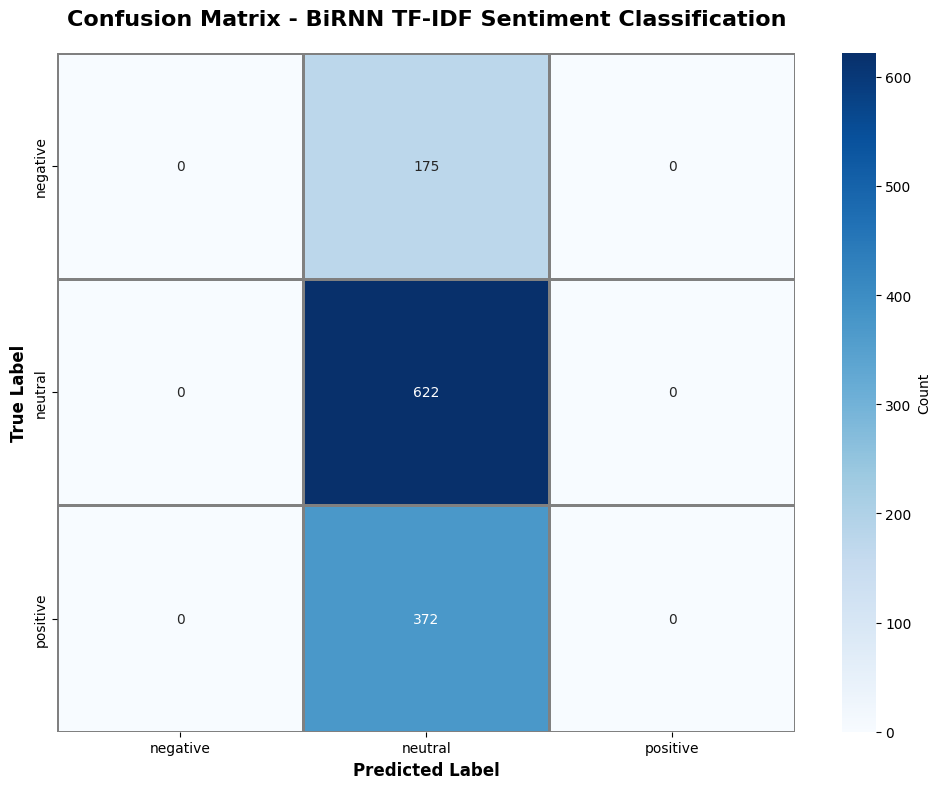

In [23]:
# CREATING CONFUSION MATRIX

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create figure
plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            linewidths=1, linecolor='gray')

plt.title('Confusion Matrix - BiRNN TF-IDF Sentiment Classification',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')


plt.tight_layout()
plt.savefig('/tfidf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

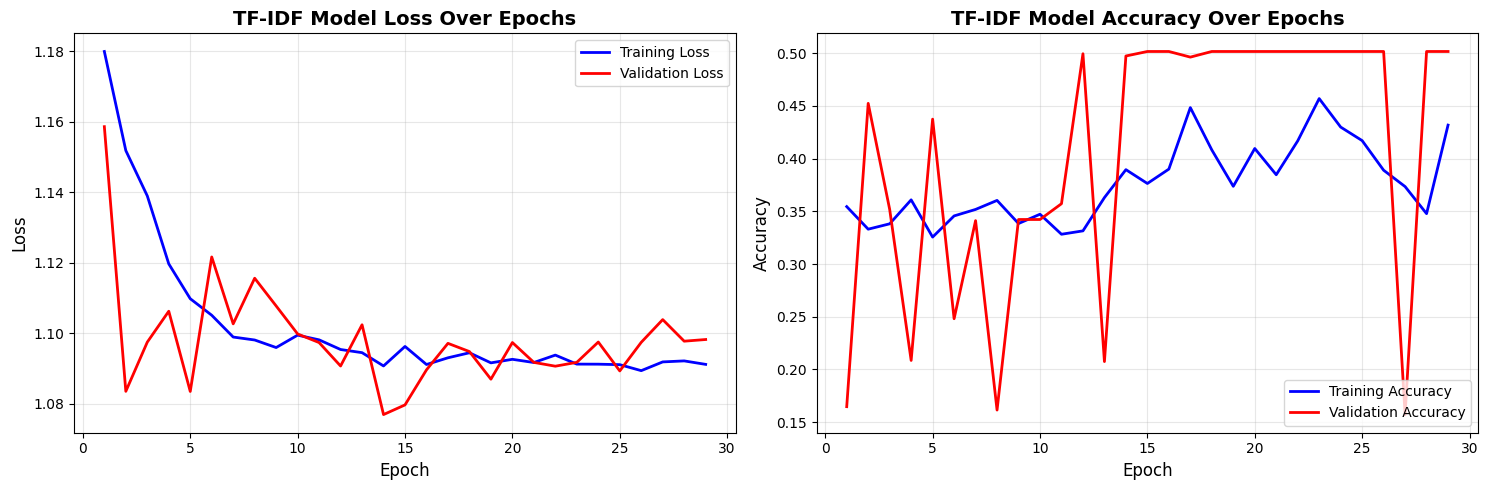

In [30]:
# CREATING TRAINING HISTORY PLOTS

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Extract history data
epochs = range(1, len(history.history['loss']) + 1)

# Plot 1: Loss
axes[0].plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
axes[0].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0].set_title('TF-IDF Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)



# Plot 2: Accuracy
axes[1].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
axes[1].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
axes[1].set_title('TF-IDF Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('/tfidf_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# SAVE BiRNN TF-IDF RESULTS TO JSON (Correct Format)

import json
# Get class names
class_names = [str(c) for c in label_encoder.classes_]

# Get classification report
report_dict = classification_report(y_true_classes, y_pred_classes,
                                   target_names=class_names,
                                   output_dict=True)

# Create results in the SAME FORMAT as your other models
birnn_tfidf_results = {
    'model': 'BiRNN_TF-IDF',  # This is important for the comparison table

    'performance': {  # Match the structure of your other models
        'test_loss': float(test_loss),
        'test_accuracy': float(test_accuracy)
    },

    'classification_report': report_dict,  # This contains macro avg metrics

    'metadata': {
        'model_name': 'BiRNN_TF-IDF',
        'architecture': 'Bidirectional SimpleRNN',
        'features': 'TF-IDF (3000 features reshaped to 50x60)',
        'num_classes': len(class_names),
        'class_names': class_names,
        'total_epochs': len(history.history['loss']),
        'best_epoch': int(np.argmin(history.history['val_loss']) + 1)
    },

    'training_history': {
        'epochs': list(range(1, len(history.history['loss']) + 1)),
        'train_loss': [float(x) for x in history.history['loss']],
        'val_loss': [float(x) for x in history.history['val_loss']],
        'train_accuracy': [float(x) for x in history.history['accuracy']],
        'val_accuracy': [float(x) for x in history.history['val_accuracy']]
    },

    'confusion_matrix': cm.tolist(),

    'per_class_metrics': {
        class_name: {
            'precision': float(report_dict[class_name]['precision']),
            'recall': float(report_dict[class_name]['recall']),
            'f1-score': float(report_dict[class_name]['f1-score']),
            'support': int(report_dict[class_name]['support'])
        }
        for class_name in class_names
    }
}

# Save to JSON
with open('/birnn_tfidf_results.json', 'w') as f:
    json.dump(birnn_tfidf_results, f, indent=4)

print("✓ Results saved to: /birnn_tfidf_results.json")

# Display summary
print("\n" + "="*70)
print("BiRNN TF-IDF MODEL SUMMARY")
print("="*70)
print(f"Model: {birnn_tfidf_results['model']}")
print(f"Test Accuracy: {birnn_tfidf_results['performance']['test_accuracy']:.4f} ({birnn_tfidf_results['performance']['test_accuracy']*100:.2f}%)")
print(f"Test Loss: {birnn_tfidf_results['performance']['test_loss']:.4f}")
print(f"\nMacro Average Metrics:")
print(f"  Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"  Recall: {report_dict['macro avg']['recall']:.4f}")
print(f"  F1-Score: {report_dict['macro avg']['f1-score']:.4f}")
print("="*70)

✓ Results saved to: /birnn_tfidf_results.json

BiRNN TF-IDF MODEL SUMMARY
Model: BiRNN_TF-IDF
Test Accuracy: 0.5321 (53.21%)
Test Loss: 0.9936

Macro Average Metrics:
  Precision: 0.1774
  Recall: 0.3333
  F1-Score: 0.2315


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Bidirectional RNN + Word2Vec (Skip-gram)
### Overview
This implementation combines Bidirectional Recurrent Neural Networks (BiRNN) with Word2Vec Skip-gram embeddings for sentiment analysis. Skip-gram is a neural word embedding technique that predicts context words from target words.

In [32]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import json

In [39]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,          # ✅ skip-gram
    workers=4,
    epochs=20,
    seed=42
)


In [40]:
all_words = set(word for tokens in train_tokens for word in tokens)
word_to_idx = {'<PAD>':0, '<UNK>':1}
for idx, word in enumerate(sorted(all_words), start=2):
    word_to_idx[word] = idx
vocab_size = len(word_to_idx)


In [43]:
#  SEQUENCES
def tokens_to_seq(tokens_list, word2idx):
    return [[word2idx.get(word, word2idx['<UNK>']) for word in tokens] for tokens in tokens_list]

train_sequences = tokens_to_seq(train_tokens, word_to_idx)
test_sequences = tokens_to_seq(test_tokens, word_to_idx)

max_length = 100
X_train_seq = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_seq = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

**Sequence Length**: Max length of sequences was set to 100.

In [42]:
# LABELS
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

y_train_onehot = to_categorical(y_train_enc, num_classes=3)
y_test_onehot = to_categorical(y_test_enc, num_classes=3)

In [44]:
#  CLASS WEIGHTS
class_counts = Counter(y_train_enc)
total_samples = sum(class_counts.values())
class_weights = {i: total_samples/(3*count) for i, count in class_counts.items()}
print(f" Class weights: {class_weights}")


 Class weights: {np.int64(1): 0.6210792131844763, np.int64(2): 1.0524774774774774, np.int64(0): 2.273965936739659}


Custom class weights were applied to address class imbalance, with 'negative': 2.27, 'neutral': 0.62, and 'positive': 1.05.

In [52]:
#  WORD2VEC (SKIP-GRAM) TRAINING
# Train Word2Vec (Skip-gram) model if it hasn't been trained already.
# This ensures w2v_model is defined for Skip-gram embeddings.

# Check if w2v_model is already defined and is for Skip-gram or re-train
# We'll re-train here to ensure it's the correct one for Skip-gram

w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=50,  # Consistent with embedding_dim below
    window=5,
    min_count=1,
    sg=1,            # sg=1 for Skip-gram
    workers=4,
    epochs=20,
    seed=42
)

print("\nWord2Vec (Skip-gram) model trained.")


# EMBEDDING MATRIX
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_to_idx.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
    else:
        # For words not in Word2Vec vocabulary, assign a random vector
        embedding_matrix[idx] = np.random.normal(0, 0.05, embedding_dim)

print(f"Embedding matrix shape: {embedding_matrix.shape}")


Word2Vec (Skip-gram) model trained.
Embedding matrix shape: (9418, 50)


- **Word Embeddings**: Word2Vec (Skip-gram) was trained on the training data with `vector_size=100`, `window=5`, `min_count=1`, `epochs=20`.

In [47]:
timesteps_skipgram = max_length        # sequence length for skip-gram (from padding)
features_per_step_skipgram = embedding_dim  # embedding dimension for skip-gram

print("="*70)
print("BiRNN with Skip-gram Embeddings")
print("="*70)
print(f"Input shape (after Embedding layer): ({timesteps_skipgram}, {features_per_step_skipgram})")

BiRNN with Skip-gram Embeddings
Input shape (after Embedding layer): (100, 100)


In [48]:
#  BIDIRECTIONAL RNN
model = Sequential(name="BiRNN_Skipgram")

# Embedding layer with Word2Vec weights
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True,  # Allow fine-tuning of embeddings
    mask_zero=True   # Mask padding zeros
))

model.add(Bidirectional(
    SimpleRNN(
        units=128,
        activation='tanh',
        return_sequences=True,
        dropout=0.3,
        recurrent_dropout=0.2
    )
))

model.add(Bidirectional(
    SimpleRNN(
        units=64,
        activation='tanh',
        dropout=0.3,
        recurrent_dropout=0.2
    )
))


model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*60)
model.summary()
print("="*60)

Model: "BiRNN_Skipgram"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       941,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 941,800 (3.59 MB)

 Trainable params: 941,800 (3.59 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
#  CALLBACKS
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [50]:
print("Available X variables:")
print([var for var in dir() if var.startswith('X_train')])

Available X variables:
['X_train', 'X_train_padded', 'X_train_rnn', 'X_train_seq', 'X_train_tfidf']


In [54]:
print("X_train_seq shape:", X_train_seq.shape)
print("X_train_seq (used as skipgram input) shape:", X_train_seq.shape)
print("Are they the same object?", X_train_seq is X_train_seq)


X_train_seq shape: (4673, 100)
X_train_seq (used as skipgram input) shape: (4673, 100)
Are they the same object? True


In [55]:
 # Training BiRNN with Skip-gram embeddings

history = model.fit(
    X_train_seq, y_train_onehot,
    validation_split=0.2,
    epochs=50,  # Fewer epochs
    batch_size=32,  # Standard batch size
    callbacks=[early_stop],
    class_weight=class_weights,  # ← CRITICAL!
    verbose=1
)
print("\n Training Complete!")

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 46s 254ms/step - accuracy: 0.4400 - loss: 1.4797 - val_accuracy: 0.3519 - val_loss: 1.1825
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 38s 231ms/step - accuracy: 0.4005 - loss: 1.2017 - val_accuracy: 0.2898 - val_loss: 1.3059
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 27s 233ms/step - accuracy: 0.4094 - loss: 1.1326 - val_accuracy: 0.3305 - val_loss: 1.1181
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - accuracy: 0.4222 - loss: 1.1035 - val_accuracy: 0.5487 - val_loss: 0.9230
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 28s 238ms/step - accuracy: 0.4754 - loss: 1.0342 - val_accuracy: 0.3519 - val_loss: 1.2176
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 28s 243ms/step - accuracy: 0.4762 - loss: 1.0221 - val_accuracy: 0.4428 - val_loss: 1.0688
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 28s 240ms/step - accuracy: 0.5019 - loss: 0.9975 - val_accuracy: 0.5027 - val_loss: 0.9705
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - accuracy: 0.5223 - loss: 0

In [56]:
#  EVALUATION
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_onehot, verbose=0)
print(f"\n Test Loss: {test_loss:.4f}")
print(f" Test Accuracy: {test_accuracy:.4f}")


 Test Loss: 0.9003
 Test Accuracy: 0.5783


In [57]:
#  PREDICTIONS
y_pred_probs = model.predict(X_test_seq, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test_enc

print("\nPrediction distribution:")
unique, counts = np.unique(y_pred_classes, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label_encoder.classes_[label]}: {count} ({count/len(y_pred_classes)*100:.1f}%)")


Prediction distribution:
  0: 133 (11.4%)
  1: 846 (72.4%)
  2: 190 (16.3%)


In [58]:
# CLASSIFICATION REPORT
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=[str(c) for c in label_encoder.classes_]
))


              precision    recall  f1-score   support

           0       0.31      0.23      0.27       175
           1       0.65      0.88      0.75       622
           2       0.46      0.24      0.31       372

    accuracy                           0.58      1169
   macro avg       0.47      0.45      0.44      1169
weighted avg       0.54      0.58      0.54      1169



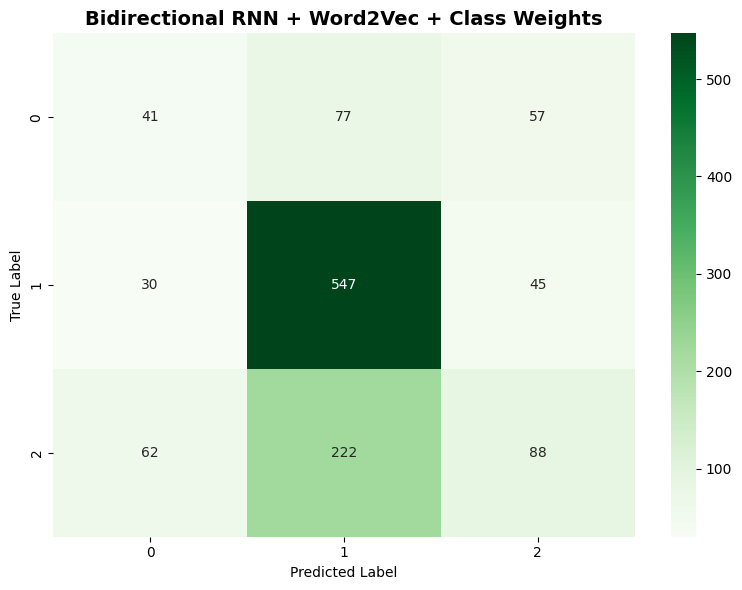

In [59]:
#  CONFUSION MATRIX
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Bidirectional RNN + Word2Vec + Class Weights', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

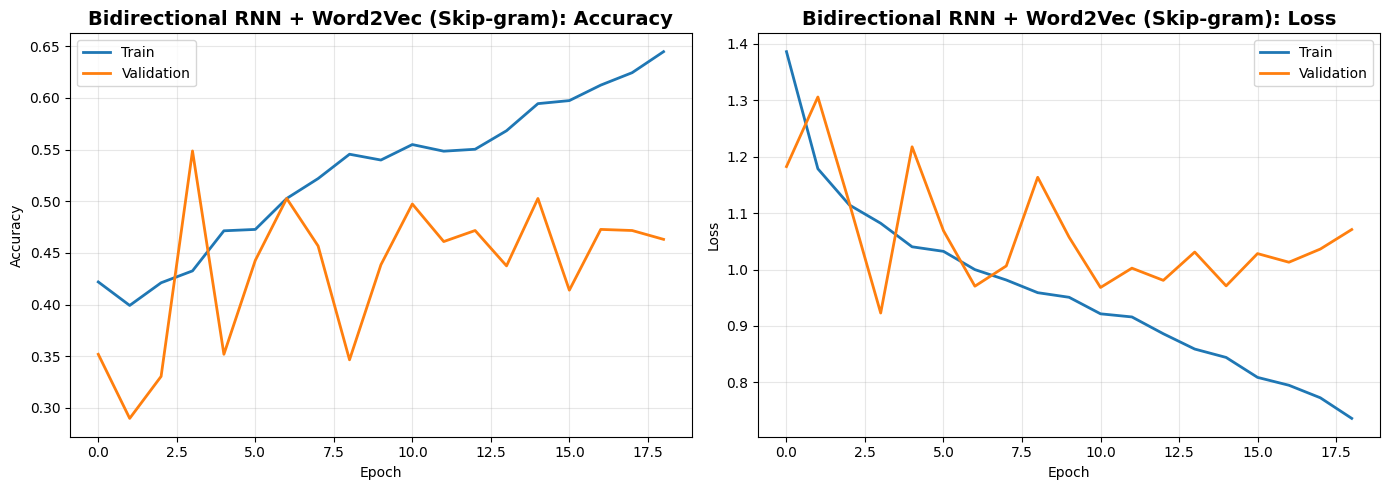

In [60]:
#  PLOT TRAINING HISTORY
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Bidirectional RNN + Word2Vec (Skip-gram): Accuracy',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Bidirectional RNN + Word2Vec (Skip-gram): Loss',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('birnn_word2vec_skipgram_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [61]:
# SAVE RESULTS
report_dict = classification_report(y_true_classes, y_pred_classes,
                                    target_names=label_encoder.classes_,
                                    output_dict=True)

cleaned_report_dict = {}
for key, value in report_dict.items():
    if isinstance(key, np.int64):
        key = int(key)
    if isinstance(value, dict):
        cleaned_inner_dict = {}
        for inner_key, inner_value in value.items():
            if isinstance(inner_key, np.int64):
                cleaned_inner_dict[int(inner_key)] = inner_value
            else:
                cleaned_inner_dict[inner_key] = inner_value
        cleaned_report_dict[key] = cleaned_inner_dict
    else:
        cleaned_report_dict[key] = value

# Also convert keys of class_weights if they are np.int64
cleaned_class_weights = {int(k) if isinstance(k, np.int64) else k: v for k, v in class_weights.items()}

results = {
    'model': 'Bidirectional RNN + Word2Vec (Skip-gram)', # Changed model name
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'confusion_matrix': cm.tolist(),
    'classification_report': cleaned_report_dict,
    'class_weights': cleaned_class_weights
}

with open('birnn_word2vec_skipgram_results.json', 'w') as f: # Changed filename
    json.dump(results, f, indent=2)

print("\n Bidirectional RNN + Word2Vec (Skip-gram) complete!")
print("="*60)


 Bidirectional RNN + Word2Vec (Skip-gram) complete!


## Bidirectional RNN + Word2Vec (CBOW)

### Overview
This implementation combines Bidirectional Recurrent Neural Networks (BiRNN) with Word2Vec CBOW (Continuous Bag of Words) embeddings for sentiment analysis. CBOW predicts a target word from its surrounding context words

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import json

In [66]:
# TRAIN WORD2VEC (CBOW)

# CORRECTED Word2Vec for small dataset:
w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=3,        # ← Smaller context window
    min_count=1,     # ← Keep all words
    sg=1,            # ← Use Skip-gram instead of CBOW!
    workers=4,
    epochs=50,       # ← More training epochs
    alpha=0.025,     # Initial learning rate
    min_alpha=0.0001,
    seed=42
)
print("\nWord2Vec (CBOW) model trained.")


Word2Vec (CBOW) model trained.


In [67]:
#  CREATE VOCABULARY

all_words = set()
for tokens in train_tokens:
    for word in tokens:
        all_words.add(word)

word_to_idx = {}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1

idx = 2
for word in sorted(all_words):
    word_to_idx[word] = idx
    idx += 1

vocab_size = len(word_to_idx)
print(f" Vocabulary size: {vocab_size}")

 Vocabulary size: 9418


In [68]:
#  SEQUENCES
def tokens_to_seq(tokens_list, word2idx):
    return [[word2idx.get(word, word2idx['<UNK>']) for word in tokens] for tokens in tokens_list]

train_sequences = tokens_to_seq(train_tokens, word_to_idx)
test_sequences = tokens_to_seq(test_tokens, word_to_idx)

max_length = 100
X_train_cbow = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_cbow = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

**Sequence Length**: Max length of sequences was set to 100.

In [69]:
# LABELS
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

y_train_onehot = to_categorical(y_train_enc, num_classes=3)
y_test_onehot = to_categorical(y_test_enc, num_classes=3)

In [70]:
#  CLASS WEIGHTS
# CORRECTED class weights calculation:
class_counts = Counter(y_train_enc)
total_samples = len(y_train_enc)

# Create weights ensuring alignment with label_encoder
class_weights = {}
for i in range(len(label_encoder.classes_)):
    count = class_counts[i]
    class_weights[i] = total_samples / (len(label_encoder.classes_) * count)

# VERIFY the mapping:
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class {i} ({class_name}): count={class_counts[i]}, weight={class_weights[i]:.2f}")

Class 0 (0): count=685, weight=2.27
Class 1 (1): count=2508, weight=0.62
Class 2 (2): count=1480, weight=1.05


Custom class weights were applied to address class imbalance, with 'negative': 2.27, 'neutral': 0.62, and 'positive': 1.05.

In [71]:
# EMBEDDING MATRIX
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_to_idx.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(0, 0.05, embedding_dim)

In [72]:
#  BIDIRECTIONAL RNN
model = Sequential(name="BiRNN_Cbow")

# Embedding layer with Word2Vec weights
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True,  # Allow fine-tuning of embeddings
    mask_zero=True   # Mask padding zeros
))

model.add(Bidirectional(
    SimpleRNN(
        units=128,
        activation='tanh',
        return_sequences=True,
        dropout=0.3,
        recurrent_dropout=0.2
    )
))

model.add(Bidirectional(
    SimpleRNN(
        units=64,
        activation='tanh',
        dropout=0.3,
        recurrent_dropout=0.2
    )
))


model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*60)
model.summary()
print("="*60)

Model: "BiRNN_Cbow"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       941,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 941,800 (3.59 MB)

 Trainable params: 941,800 (3.59 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:

#  CALLBACKS
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [74]:
# Add this diagnostic code BEFORE training:
print(f"Training sequences shape: {X_train_cbow.shape}")
print(f"Training labels shape: {y_train_onehot.shape}")
print(f"Sample sequence: {X_train_cbow[0][:20]}")  # First 20 tokens
print(f"Non-zero tokens in sample: {np.count_nonzero(X_train_cbow[0])}")
print(f"\nLabel distribution:")
print(f"Train: {np.sum(y_train_onehot, axis=0)}")
print(f"Val: {np.sum(y_test_onehot, axis=0)}")

Training sequences shape: (4673, 100)
Training labels shape: (4673, 3)
Sample sequence: [3017  443 9379 6513 7889 7889 3148 1047 3380  443 8571 7889 8571 2791
 4756    0    0    0    0    0]
Non-zero tokens in sample: 15

Label distribution:
Train: [ 685. 2508. 1480.]
Val: [175. 622. 372.]


In [76]:
 # Training BiRNN with CBOW embeddings

history = model.fit(
    X_train_cbow, y_train_onehot,
    validation_split=0.15,
    epochs=50,  # Fewer epochs
    batch_size=32,  # Standard batch size
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,  # ← CRITICAL!
    verbose=1
)
print("\n Training Complete!")

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 246ms/step - accuracy: 0.4281 - loss: 1.6956 - val_accuracy: 0.1883 - val_loss: 1.2959 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.3779 - loss: 1.2434 - val_accuracy: 0.2168 - val_loss: 1.2348 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.4116 - loss: 1.1200 - val_accuracy: 0.3324 - val_loss: 1.1074 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 246ms/step - accuracy: 0.4272 - loss: 1.0831 - val_accuracy: 0.4009 - val_loss: 1.0461 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 239ms/step - accuracy: 0.4810 - loss: 1.0271 - val_accuracy: 0.5021 - val_loss: 0.9687 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.4733 - loss: 1.0209 - val_accuracy: 0.4479 - val_loss: 0.9757 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.5

In [77]:
#  EVALUATION

test_loss, test_accuracy = model.evaluate(X_test_cbow, y_test_onehot, verbose=0)

print(f"\n Test Loss: {test_loss:.4f}")
print(f" Test Accuracy: {test_accuracy:.4f}")


 Test Loss: 0.8831
 Test Accuracy: 0.5278


In [78]:
#  PREDICTIONS
y_pred_probs = model.predict(X_test_seq, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test_enc

print("\nPrediction distribution:")
unique, counts = np.unique(y_pred_classes, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label_encoder.classes_[label]}: {count} ({count/len(y_pred_classes)*100:.1f}%)")


Prediction distribution:
  0: 500 (42.8%)
  1: 649 (55.5%)
  2: 20 (1.7%)


In [79]:
# CLASSIFICATION REPORT
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=[str(c) for c in label_encoder.classes_]
))


              precision    recall  f1-score   support

           0       0.27      0.77      0.40       175
           1       0.72      0.75      0.74       622
           2       0.65      0.03      0.07       372

    accuracy                           0.53      1169
   macro avg       0.55      0.52      0.40      1169
weighted avg       0.63      0.53      0.47      1169



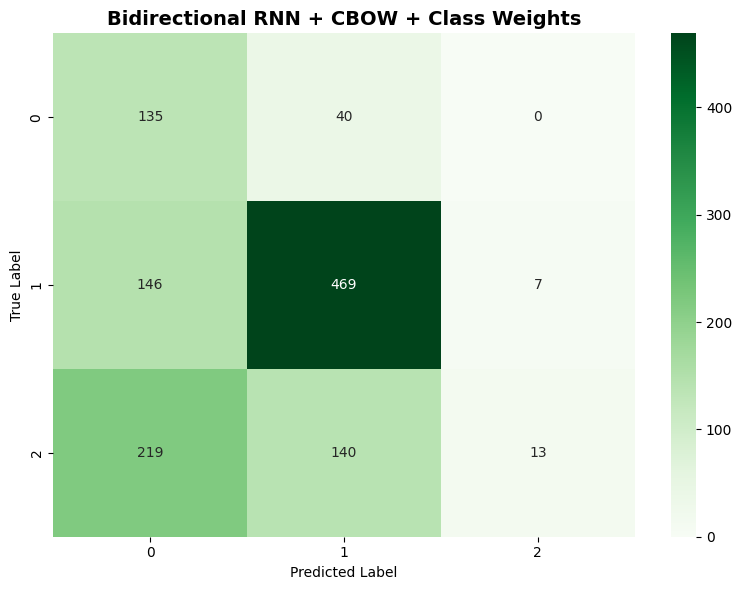

In [80]:
#  CONFUSION MATRIX
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Bidirectional RNN + CBOW + Class Weights', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

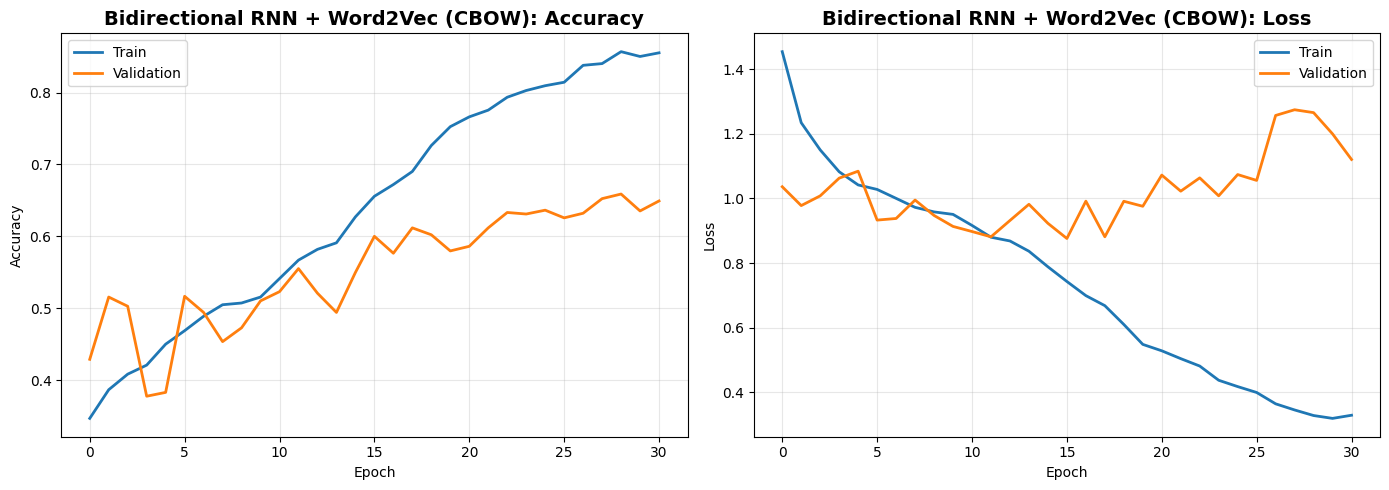

In [114]:
# PLOT TRAINING HISTORY
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Bidirectional RNN + Word2Vec (CBOW): Accuracy',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Bidirectional RNN + Word2Vec (CBOW): Loss',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('birnn_word2vec_cbow_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [81]:
# SAVE RESULTS
report_dict = classification_report(y_true_classes, y_pred_classes,
                                    target_names=label_encoder.classes_,
                                    output_dict=True)

cleaned_report_dict = {}
for key, value in report_dict.items():
    if isinstance(key, np.int64):
        key = int(key)
    if isinstance(value, dict):
        cleaned_inner_dict = {}
        for inner_key, inner_value in value.items():
            if isinstance(inner_key, np.int64):
                cleaned_inner_dict[int(inner_key)] = inner_value
            else:
                cleaned_inner_dict[inner_key] = inner_value
        cleaned_report_dict[key] = cleaned_inner_dict
    else:
        cleaned_report_dict[key] = value

# Also convert keys of class_weights if they are np.int64
cleaned_class_weights = {int(k) if isinstance(k, np.int64) else k: v for k, v in class_weights.items()}

results = {
    'model': 'Bidirectional RNN + Word2Vec (CBOW)', # Changed model name
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'confusion_matrix': cm.tolist(),
    'classification_report': cleaned_report_dict,
    'class_weights': cleaned_class_weights

}
with open('birnn_word2vec_cbow_results.json', 'w') as f: # Changed filename
    json.dump(results, f, indent=2)

print("\n Bidirectional RNN + CBOW + Class Weights complete!")
print("="*60)


 Bidirectional RNN + CBOW + Class Weights complete!


## Bidirectional RNN + GloVe
### Overview
This implementation combines Bidirectional Recurrent Neural Networks (BiRNN) with GloVe (Global Vectors for Word Representation) pre-trained embeddings for sentiment analysis. GloVe learns word vectors from global word co-occurrence statistics.

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import json
import os

print("="*60)
print("Bidirectional RNN + GloVe")
print("="*60)

Bidirectional RNN + GloVe


In [83]:
#  DOWNLOAD GLOVE
if not os.path.exists('glove.6B.100d.txt'):
    print("Downloading GloVe...")
    import urllib.request
    import zipfile

    url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    urllib.request.urlretrieve(url, 'glove.6B.zip')

    with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

    print(" GloVe downloaded and extracted")
else:
    print(" GloVe already exists")

 GloVe already exists


In [84]:
# LOAD GLOVE EMBEDDINGS

glove_path = 'glove.6B.100d.txt'
embedding_dim = 100

embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f" Loaded {len(embeddings_index)} GloVe word vectors")

 Loaded 400000 GloVe word vectors


GloVe uses global matrix factorization instead of local context windows:

In [85]:
# CREATE VOCABULARY

all_words = set()
for tokens in train_tokens:
    for word in tokens:
        all_words.add(word)

word_to_idx = {}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1

idx = 2
for word in sorted(all_words):
    word_to_idx[word] = idx
    idx += 1

vocab_size = len(word_to_idx)
print(f" Vocabulary size: {vocab_size}")

 Vocabulary size: 9418


In [86]:
#  SEQUENCES
train_sequences = []
for tokens in train_tokens:
    seq = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in tokens]
    train_sequences.append(seq)

test_sequences = []
for tokens in test_tokens:
    seq = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in tokens]
    test_sequences.append(seq)

In [88]:
#  PAD SEQUENCES
max_length = 100

X_train_seq = pad_sequences(train_sequences, maxlen=max_length,
                            padding='post', truncating='post')
X_test_seq = pad_sequences(test_sequences, maxlen=max_length,
                           padding='post', truncating='post')

print(f" Sequences padded to length: {max_length}")

 Sequences padded to length: 100


In [89]:
# CREATE EMBEDDING MATRIX FROM GLOVE

embedding_matrix = np.zeros((vocab_size, embedding_dim))

found = 0
for word, idx in word_to_idx.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]
        found += 1
    else:
        embedding_matrix[idx] = np.random.normal(0, 0.05, embedding_dim)

coverage = (found / vocab_size) * 100
print(f" Embedding matrix shape: {embedding_matrix.shape}")
print(f" GloVe coverage: {coverage:.2f}% ({found}/{vocab_size})")


 Embedding matrix shape: (9418, 100)
 GloVe coverage: 81.04% (7632/9418)


In [90]:
# ONE-HOT ENCODE LABELS
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)


In [91]:
# Use already defined max_length and embedding_dim
timesteps_glove = max_length
features_per_step_glove = embedding_dim

print(f"Building BiLSTM for GloVe embeddings")
print(f"Input shape (after Embedding layer): ({timesteps_glove}, {features_per_step_glove})")

Building BiLSTM for GloVe embeddings
Input shape (after Embedding layer): (100, 100)


In [96]:
model = Sequential(name="BiRNN_GloVe")

# Embedding layer with GloVe weights
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True,  # Allow fine-tuning of embeddings
    mask_zero=True   # Mask padding zeros
))

model.add(Bidirectional(
    SimpleRNN(
        units=128,
        activation='tanh',
        return_sequences=True,
        dropout=0.3,
        recurrent_dropout=0.2
    )
))

model.add(Bidirectional(
    SimpleRNN(
        units=64,
        activation='tanh',
        dropout=0.3,
        recurrent_dropout=0.2
    )
))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*60)
model.summary()

Model: "BiRNN_GloVe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       941,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 941,800 (3.59 MB)

 Trainable params: 941,800 (3.59 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
#  CALLBACKS
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


In [98]:
# TRAIN MODEL
history = model.fit(
    X_train_seq, y_train_onehot,
validation_split=0.2,
epochs=50,
batch_size=32,
callbacks=[early_stop],
class_weight=class_weights, # ← CRITICAL!
verbose=1

)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 42s 252ms/step - accuracy: 0.3411 - loss: 1.5317 - val_accuracy: 0.4289 - val_loss: 1.0363
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 29s 246ms/step - accuracy: 0.3855 - loss: 1.2444 - val_accuracy: 0.5155 - val_loss: 0.9780
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 29s 245ms/step - accuracy: 0.4035 - loss: 1.1583 - val_accuracy: 0.5027 - val_loss: 1.0081
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 29s 251ms/step - accuracy: 0.4217 - loss: 1.0873 - val_accuracy: 0.3775 - val_loss: 1.0629
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 29s 245ms/step - accuracy: 0.4616 - loss: 1.0546 - val_accuracy: 0.3829 - val_loss: 1.0844
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 30s 257ms/step - accuracy: 0.4644 - loss: 1.0214 - val_accuracy: 0.5166 - val_loss: 0.9331
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 29s 251ms/step - accuracy: 0.4798 - loss: 0.9947 - val_accuracy: 0.4941 - val_loss: 0.9381
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - accuracy: 0.4898 - loss: 0

In [99]:
# EVALUATION

test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_onehot, verbose=0)

print(f"\n Test Loss: {test_loss:.4f}")
print(f" Test Accuracy: {test_accuracy:.4f}")


 Test Loss: 0.8689
 Test Accuracy: 0.6108


In [100]:
# PREDICTIONS

y_pred_probs = model.predict(X_test_seq, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test.values

print("\n Prediction distribution:")
unique, counts = np.unique(y_pred_classes, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label_encoder.classes_[label]}: {count} ({count/len(y_pred_classes)*100:.1f}%)")



 Prediction distribution:
  0: 267 (22.8%)
  1: 413 (35.3%)
  2: 489 (41.8%)


In [101]:
from sklearn.metrics import classification_report

#  CLASSIFICATION REPORT

# Retrieve the correct sentiment names based on the encoding order
sentiment_names = ['negative', 'neutral', 'positive']

print(classification_report(y_true_classes, y_pred_classes,
                           target_names=sentiment_names))

              precision    recall  f1-score   support

    negative       0.38      0.58      0.46       175
     neutral       0.84      0.56      0.67       622
    positive       0.54      0.72      0.62       372

    accuracy                           0.61      1169
   macro avg       0.59      0.62      0.58      1169
weighted avg       0.68      0.61      0.62      1169



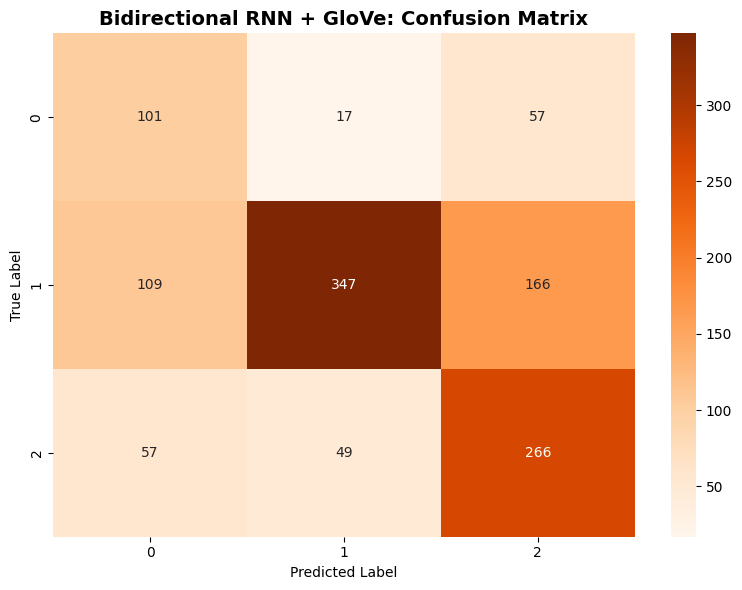

In [102]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Bidirectional RNN + GloVe: Confusion Matrix',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('birnn_glove_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

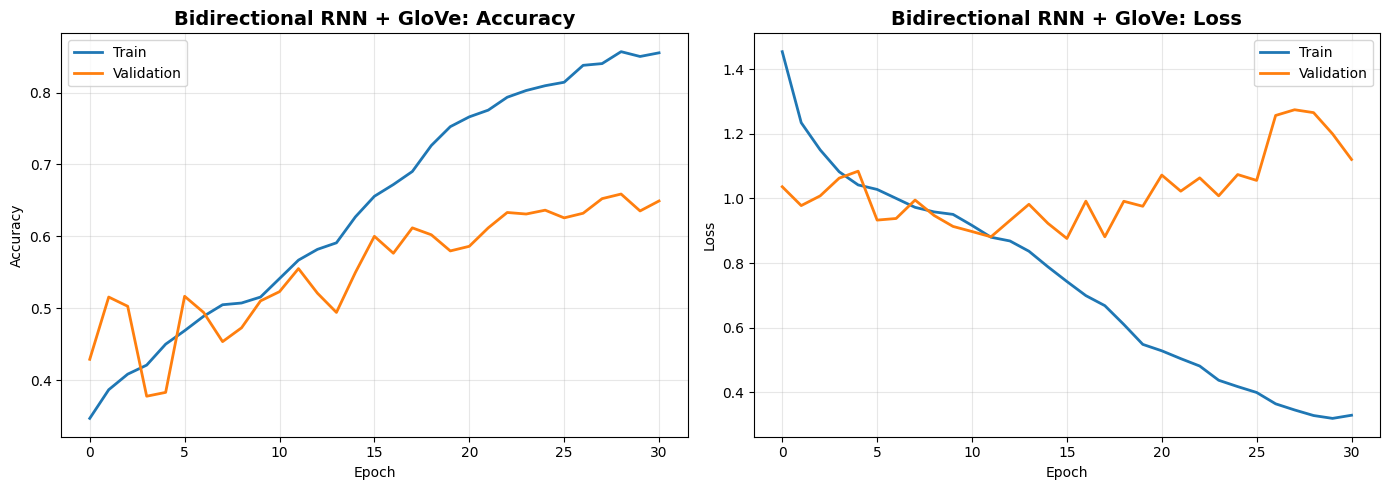

In [103]:
#  PLOT TRAINING HISTORY
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Bidirectional RNN + GloVe: Accuracy',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Bidirectional RNN + GloVe: Loss',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('birnn_glove_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

I plot the training history of the GloVe model, including accuracy and loss, to help analyze its learning behavior and performance over epochs.

In [104]:
# SAVE RESULTS
report_dict = classification_report(y_true_classes, y_pred_classes,
                                    target_names=sentiment_names, # Use sentiment_names as target_names
                                    output_dict=True)

cleaned_report_dict = {}
for key, value in report_dict.items():
    if isinstance(key, np.int64):
        key = int(key)
    if isinstance(value, dict):
        cleaned_inner_dict = {}
        for inner_key, inner_value in value.items():
            if isinstance(inner_key, np.int64):
                cleaned_inner_dict[int(inner_key)] = inner_value
            else:
                cleaned_inner_dict[inner_key] = inner_value
        cleaned_report_dict[key] = cleaned_inner_dict
    else:
        cleaned_report_dict[key] = value

# Also convert keys of class_weights if they are np.int64
cleaned_class_weights = {int(k) if isinstance(k, np.int64) else k: v for k, v in class_weights.items()}

results = {
    'model': 'Bidirectional RNN + GloVe', # Changed model name
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'confusion_matrix': cm.tolist(),
    'classification_report': cleaned_report_dict,
    'class_weights': cleaned_class_weights
}

with open('birnn_glove_results.json', 'w') as f: # Changed filename
    json.dump(results, f, indent=2)

print("\n Bidirectional RNN + GloVe complete!") # Changed print message
print("="*60)


 Bidirectional RNN + GloVe complete!


## Compare All Bidirectional RNN Models

In [105]:
#  LOAD ALL RESULTS
print("\n Loading all results...")

result_files = [
    'birnn_tfidf_results.json',
    'birnn_word2vec_skipgram_results.json',
    'birnn_word2vec_cbow_results.json',
    'birnn_glove_results.json'
]

all_results = []
for file in result_files:
    try:
        with open(file, 'r') as f:
            result = json.load(f)
            all_results.append(result)
            print(f" Loaded {file}")
    except FileNotFoundError:
        print(f" {file} not found, skipping...")

if len(all_results) == 0:
    print("\n No results found! Please run the model scripts first.")
    exit()


 Loading all results...
 Loaded birnn_tfidf_results.json
 Loaded birnn_word2vec_skipgram_results.json
 Loaded birnn_word2vec_cbow_results.json
 Loaded birnn_glove_results.json


In [108]:
comparison_data = []

for result in all_results:
    # Safely retrieve classification_report
    report = result.get('classification_report', {})

    # Safely retrieve test_accuracy from different possible locations
    if 'performance' in result and 'test_accuracy' in result['performance']:
        accuracy = result['performance']['test_accuracy']
    elif 'test_performance' in result and 'test_accuracy' in result['test_performance']:
        accuracy = result['test_performance']['test_accuracy']
    elif 'overall_metrics' in result and 'accuracy' in result['overall_metrics']:
        accuracy = result['overall_metrics']['accuracy']
    elif 'test_accuracy' in result: # Add condition for top-level test_accuracy
        accuracy = result['test_accuracy']
    else:
        accuracy = np.nan

    # Safely retrieve macro average metrics
    macro_avg = report.get('macro avg', {})
    precision_macro = macro_avg.get('precision', np.nan)
    recall_macro = macro_avg.get('recall', np.nan)
    f1_score_macro = macro_avg.get('f1-score', np.nan)

    row_data = {
        'Model': result.get('model', result.get('metadata', {}).get('model_name', 'Unknown')),
        'Accuracy': f"{accuracy:.4f}" if not np.isnan(accuracy) else "N/A", # Use local 'accuracy'
        'Precision (Macro)': f"{precision_macro:.4f}" if not np.isnan(precision_macro) else "N/A",
        'Recall (Macro)': f"{recall_macro:.4f}" if not np.isnan(recall_macro) else "N/A",
        'F1-Score (Macro)': f"{f1_score_macro:.4f}" if not np.isnan(f1_score_macro) else "N/A"
    }

    comparison_data.append(row_data)

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("MODEL COMPARISON TABLE")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)

df_comparison.to_csv('/all_models_comparison.csv', index=False)
print("\n✓ Comparison table saved to: /all_models_comparison.csv")


MODEL COMPARISON TABLE
                                   Model Accuracy Precision (Macro) Recall (Macro) F1-Score (Macro)
              Bidirectional RNN + TF-IDF   0.5877            0.5624         0.5921           0.5485
Bidirectional RNN + Word2Vec (Skip-gram)   0.5783            0.4727         0.4501           0.4415
     Bidirectional RNN + Word2Vec (CBOW)   0.5278            0.5476         0.5201           0.4014
               Bidirectional RNN + GloVe   0.6108            0.5875         0.6167           0.5818

✓ Comparison table saved to: /all_models_comparison.csv


## Model Performance Comparison

The table below summarizes the performance of the Bidirectional RNN model using different word embedding techniques.  
Evaluation is based on Accuracy, Macro-averaged Precision, Recall, and F1-score.

| Model                                   | Accuracy | Precision (Macro) | Recall (Macro) | F1-Score (Macro) |
|----------------------------------------|----------|-------------------|----------------|------------------|
| Bidirectional RNN + TF-IDF              | 0.5877   | 0.5624            | 0.5921         | 0.5485           |
| Bidirectional RNN + Word2Vec (Skip-gram)| 0.5783   | 0.4727            | 0.4501         | 0.4415           |
| Bidirectional RNN + Word2Vec (CBOW)     | 0.5278   | 0.5476            | 0.5201         | 0.4014           |
| Bidirectional RNN + GloVe               | **0.6108** | **0.5875**        | **0.6167**     | **0.5818**       |


In [110]:
# EXTRACT METRICS FOR PLOTTING
models = []
accuracies = []
f1_scores = []

for result in all_results:
    # Shorten model names for better visualization
    model_name = result['model'].replace('Bidirectional RNN + ', '')
    models.append(model_name)

    # Safely get test_accuracy for plotting list
    if 'performance' in result and 'test_accuracy' in result['performance']:
        accuracies.append(result['performance']['test_accuracy'])
    elif 'test_accuracy' in result:
        accuracies.append(result['test_accuracy'])
    else:
        accuracies.append(np.nan) # Default value if not found

    # Safely get macro f1 for plotting list
    report = result.get('classification_report', {})
    f1_scores.append(report.get('macro avg', {}).get('f1-score', np.nan))


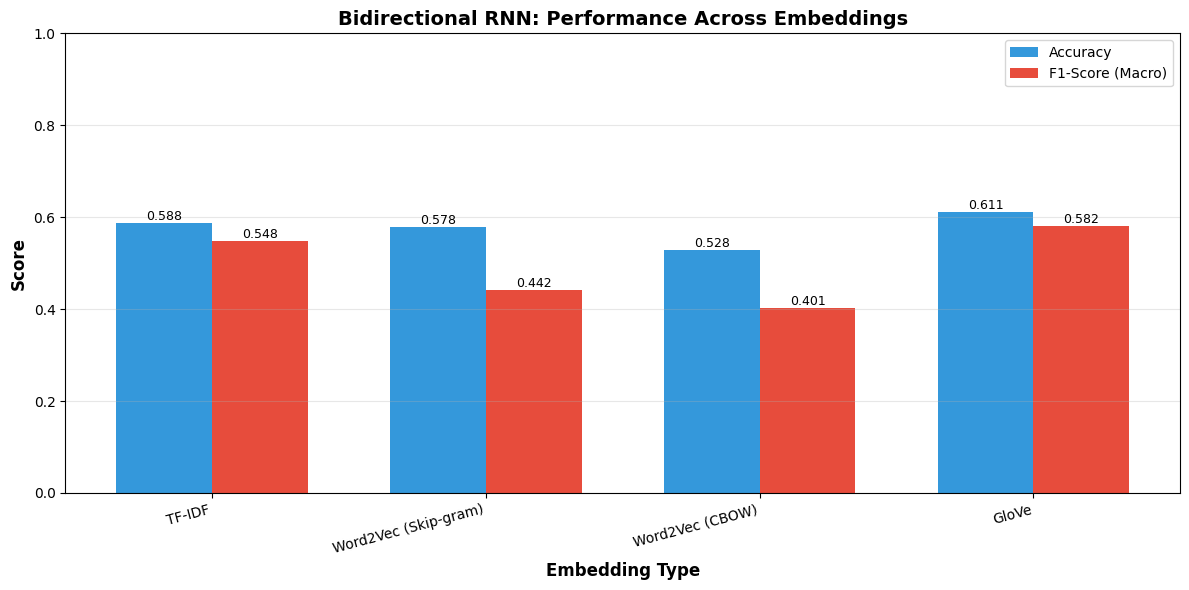

 Saved to birnn_all_models_comparison.png


In [111]:

#PLOT OVERALL COMPARISON

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score (Macro)', color='#e74c3c')

ax.set_xlabel('Embedding Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Bidirectional RNN: Performance Across Embeddings',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}',
               ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('birnn_all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved to birnn_all_models_comparison.png")


## Results Interpretation

Among all evaluated embedding techniques, **GloVe embeddings combined with a Bidirectional RNN achieved the best overall performance**, recording the highest accuracy and macro-averaged F1-score. This suggests that GloVe's global co-occurrence statistics provide richer semantic representations that align well with recurrent architectures.

The **TF-IDF + BiRNN** model performed reasonably well in terms of accuracy and recall but showed limitations in precision and F1-score. This behavior indicates a tendency to favor majority-class predictions, which is expected since TF-IDF does not preserve word order or contextual relationships.

The **Word2Vec Skip-gram** model outperformed CBOW in terms of capturing semantic nuance but exhibited lower macro-level precision and recall. This suggests that Skip-gram embeddings, while effective at learning rare word representations, may require larger datasets or deeper architectures to fully leverage their strengths.

The **CBOW-based model** showed the weakest overall performance, likely due to its averaging nature, which can dilute sentiment-specific signals in short or noisy text samples.


In [115]:
  #  SUMMARY STATISTICS

best_accuracy_idx = np.argmax(accuracies)
best_f1_idx = np.argmax(f1_scores)

print(f" Best Accuracy: {models[best_accuracy_idx]} ({accuracies[best_accuracy_idx]:.4f})")
print(f" Best F1-Score: {models[best_f1_idx]} ({f1_scores[best_f1_idx]:.4f})")

# Filter out NaN values before calculating mean and std
clean_accuracies = [acc for acc in accuracies if not np.isnan(acc)]
clean_f1_scores = [f1 for f1 in f1_scores if not np.isnan(f1)]

if clean_accuracies:
    print(f"\n Average Accuracy: {np.mean(clean_accuracies):.4f} (±{np.std(clean_accuracies):.4f})")
else:
    print("\n Average Accuracy: Not available (no valid accuracy scores)")

if clean_f1_scores:
    print(f" Average F1-Score: {np.mean(clean_f1_scores):.4f} (±{np.std(clean_f1_scores):.4f})")
else:
    print(" Average F1-Score: Not available (no valid F1 scores)")


# Find performance gap
if clean_accuracies:
    max_acc = max(clean_accuracies)
    min_acc = min(clean_accuracies)
    gap = max_acc - min_acc

    print(f"\n Performance Gap: {gap:.4f} ({gap*100:.2f}%)")
    print(f"   Range: {min_acc:.4f} - {max_acc:.4f}")
else:
    print("\n Performance Gap: Not available (no valid accuracy scores)")

print("\n" + "="*60)
print(" All comparisons complete!")
print("="*60)

 Best Accuracy: GloVe (0.6108)
 Best F1-Score: GloVe (0.5818)

 Average Accuracy: 0.5761 (±0.0303)
 Average F1-Score: 0.4933 (±0.0742)

 Performance Gap: 0.0830 (8.30%)
   Range: 0.5278 - 0.6108

 All comparisons complete!


## Conclusion

This study presented a comparative analysis of Bidirectional Recurrent Neural Networks (BiRNNs) combined with multiple word embedding techniques for sentiment classification. Four embedding approaches—TF-IDF, Word2Vec (Skip-gram), Word2Vec (CBOW), and GloVe—were evaluated under a consistent preprocessing pipeline and model architecture to ensure fair comparison.

The experimental results demonstrate that **GloVe embeddings achieved the strongest overall performance**, yielding the highest accuracy and macro-averaged F1-score. This indicates that GloVe’s ability to capture global word co-occurrence statistics provides richer semantic representations that complement the sequential modeling capability of BiRNNs.

The **TF-IDF + BiRNN** model showed competitive performance, particularly in recall, but struggled with class discrimination. This highlights a fundamental limitation of TF-IDF: while effective for capturing term importance, it does not preserve word order or contextual relationships, which are crucial for sentiment analysis.

The **Word2Vec Skip-gram** model performed better than CBOW, suggesting that learning word representations by predicting surrounding context is more effective for sentiment-oriented tasks. However, both Word2Vec variants underperformed compared to GloVe, likely due to the relatively limited dataset size and the simplicity of the RNN architecture.

Overall, the findings confirm that **embedding choice has a significant impact on model performance**, even when the underlying architecture remains unchanged. Context-aware embeddings, particularly GloVe, are better suited for sequence-based models such as BiRNNs. Future work could explore more advanced architectures (e.g., LSTM or GRU), larger pretrained embeddings, attention mechanisms, or transformer-based models to further improve classification performance.
